In [1]:
import pandas as pd

In [2]:
df = pd.read_pickle('taxonomy_working.pkl')

In [3]:
df.head()

,Responsable,T1,T2,item_name_x,item_description_x,item_code,frn_id,category,item_name_y,item_description_y,item_text,tokens
0,Ana,Pollo,Alitas,Alitas 10 piezas,Salsa a elegir.,72365267,266868,Snacks,Alitas 10 piezas,Salsa a elegir.,snacks alitas piezas salsa a elegir,"[snacks, alitas, piezas, salsa, elegir]"
1,Rodo,Saludable,Ensalada,Ensalada Philadelphia,"A elegir 1 Cama de lechugas Frescas, Más 3 Sem...",69394214,252803,Ensaladas,Ensalada Philadelphia,A elegir 1 Cama de lechugas Frescas Más 3 Sem...,ensaladas ensalada philadelphia a elegir cama ...,"[ensaladas, ensalada, philadelphia, elegir, ca..."
2,Jose,Tacos,Tacos Otros,Hamburguesa Valdéz,"200 grs. De molida de sirloin, pan artesanal, ...",65,207665,Hamburguesas al Carbón,Hamburguesa Valdéz,200 grs. De molida de sirloin pan artesanal ...,hamburguesas al carbón hamburguesa valdéz grs ...,"[hamburguesas, carbón, hamburguesa, valdéz, mo..."
3,Alfredo,Hamburguesas,Hamburguesa,LA BBQ DE LUXE!,"pan artesanal,jitomate, cebolla lechuga, pepin...",33141492,48028,HAMBURGUESAS AL CARBON,LA BBQ DE LUXE!,pan artesanal jitomate cebolla lechuga pepin...,hamburguesas al carbon la bbq de luxe pan arte...,"[hamburguesas, carbon, bbq, luxe, pan, artesan..."
4,Ana,Pizza,Pizza gourmet,2 Pizza Grande 4 Ingredientes.,"Base de salsa pomodora, queso mozzarella y que...",539849,539157,Pizzas,2 Pizza Grande 4 Ingredientes.,Base de salsa pomodora queso mozzarella y que...,pizzas pizza grande ingredientes base de salsa...,"[pizzas, pizza, ingredientes, base, salsa, pom..."


## tfidf

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

vectorizer = TfidfVectorizer(min_df=10, max_features=10000, ngram_range=(1, 2),
                             decode_error = 'replace')
vz = vectorizer.fit_transform(list(df.tokens.map(lambda x:' '.join(x))))
vz.shape


(334227, 10000)

In [5]:
# pd.DataFrame(vz.todense()).head(26)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

## dimensionality reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

dim = 750

svd = TruncatedSVD(n_components=dim, random_state=0)
svd_tfidf = svd.fit_transform(vz)
print(svd_tfidf.shape)
print(sum(svd.explained_variance_))

In [11]:
svd_tfidf[0]

array([ 8.68153417e-03,  9.74332221e-02, -3.43233952e-03,  2.17376764e-02,
        7.17801082e-02,  8.50392984e-02, -8.72199772e-02,  9.78603156e-02,
       -4.75003250e-02, -3.07777514e-02,  3.66544186e-01, -4.01883393e-02,
       -9.63061927e-02, -8.79654039e-03,  3.78291697e-02, -1.03614963e-02,
        7.02664134e-02, -5.90488132e-02, -6.66650755e-02, -6.68263392e-03,
        9.24832797e-03, -3.03112605e-02, -1.03223948e-02, -1.53643375e-02,
        3.74742744e-02, -1.28409891e-02,  4.21735932e-03, -7.54466184e-03,
        1.38103298e-03,  4.92075772e-03,  1.55043333e-02,  1.46923522e-03,
        8.99346060e-03, -5.80680225e-02,  8.07666019e-03, -8.63766300e-02,
        1.00796058e-01, -8.98671644e-02, -1.66573707e-02, -2.16844373e-02,
       -7.90538295e-03, -5.82315122e-02,  1.94417473e-01,  2.56769327e-03,
       -1.19307084e-01, -4.03548919e-02,  1.02396566e-01,  5.30203366e-02,
       -1.44989287e-02,  1.14444295e-02, -3.94530621e-02, -5.09890161e-02,
       -3.91202241e-02, -

## Logistic regression

In [7]:
# Naive class imbalance correction
imbal = df.T2.value_counts().index[df.T2.value_counts() < 10]

df['T2_isimbal'] = df.T2.map(lambda x: x in list(imbal))
df['T2_corrected'] = df.T2

df.loc[df.T2_isimbal,['T2_corrected']] = 'Otros otros' 


In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.T2_corrected.map(str))

le.classes_

y = le.transform(df.T2_corrected.map(str))
X = svd_tfidf
# le.inverse_transform([0, 0, 1, 2])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)


In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

clf.score(X_test, y_test)


/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.737471952131638

In [11]:
clf.get_params


<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)>

In [15]:
import numpy as np
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [16]:
# Grid search cross validation
import numpy as np
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,5), "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver = 'lbfgs',multi_class='auto',max_iter=250)
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs 

tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'penalty': 'l2'}
accuracy : 0.7354041916167665


In [111]:
from sklearn import metrics

y_pred = logreg_cv.predict(X_test)
metrics.confusion_matrix(y_test, y_pred)

array([[ 3,  0,  0, ...,  0,  0,  0],
       [ 0,  3,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  1,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  0, 21,  2],
       [ 0,  0,  0, ...,  0,  3, 36]])

In [17]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [18]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)

    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


In [21]:
clf.score(X_train, y_train)


0.7930389221556886

In [20]:
y_pred = clf.predict(X_train)

multiclass_roc_auc_score(y_train,y_pred)

0.7896026290271176

In [23]:
import seaborn as sn
import matplotlib.pyplot as plt 

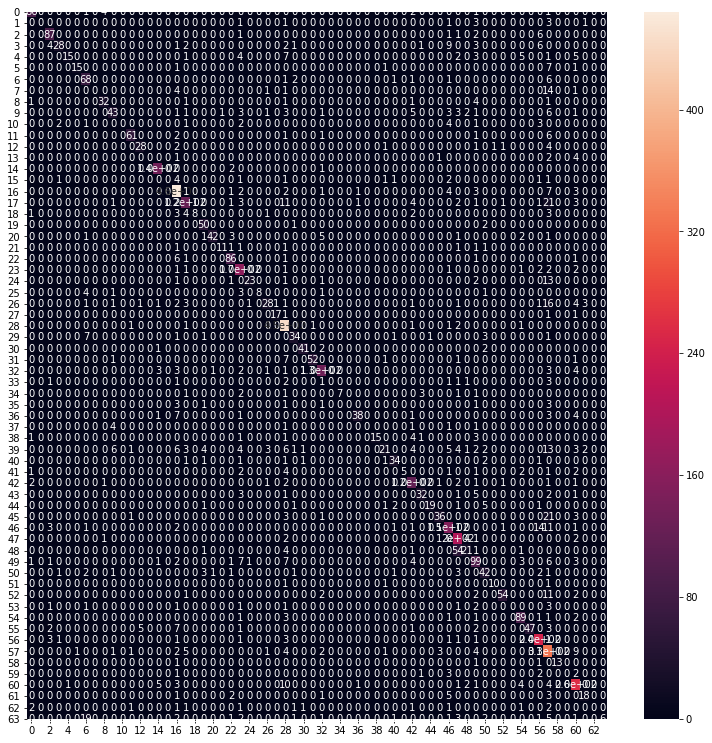

In [25]:
from sklearn import metrics
plt.figure(figsize = (13,13))
sn.heatmap(metrics.confusion_matrix(y_train, y_pred), annot=True)


## Random Forest

In [127]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [128]:
#  Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 74.7min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 91.1min finished
/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [133]:
print(rf_random.best_score_)
print(rf_random.best_params_)

0.6197183098591549
{'n_estimators': 1550, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 43, 'bootstrap': False}


In [134]:
rf.fit(X_train, y_train)


/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)